In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
sys.path.append("../../")
from neurotools.emg_tools.hd_sEMG import NeuroNexus_H32_tri,NeuroNexus_H32_tri_interp,HD_sEMG,interpolate_HD_sEMG
from neurotools.emg_tools.emg_channel import eEMG
from neurotools.ns5_tools.ns5_tools import ns5Files
from neurotools.utils.trigger import trigger as trigger_b

## Let's look at the electrode geometry (with and without interpolation)

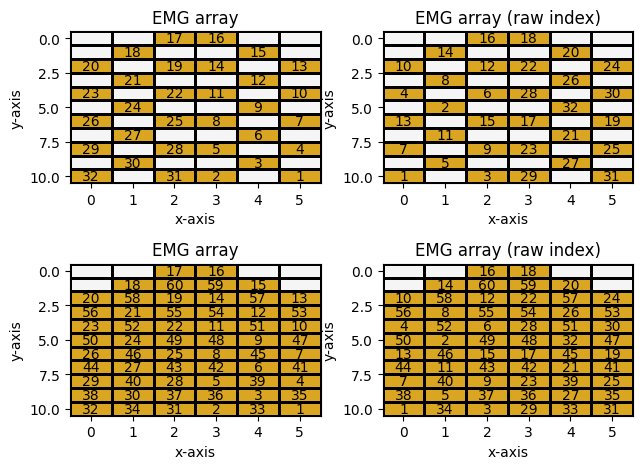

In [2]:
fig, axs = plt.subplots(2,2) 
NeuroNexus_H32_tri.plot_grid(axs[0,0])
NeuroNexus_H32_tri.plot_grid(axs[0,1], raw_idx=True)
NeuroNexus_H32_tri_interp.plot_grid(axs[1,0])
NeuroNexus_H32_tri_interp.plot_grid(axs[1,1], raw_idx=True)
fig.tight_layout()

##  Open a file and create a HD_sEMG object (without interpolation)

In [3]:
##create or open the EMG arrays
keys = NeuroNexus_H32_tri.required_raw_keys() + ['Tr0 ', 'Tr1 ']

data_file = "./source/test_emg_array.hdf5"
overwrite = False
if not (os.path.isfile(data_file)) or overwrite:
    ns5_path = "./source/UA014_SEL_AS_MS_SGM0_0009.ns5"
    ns5_file = ns5Files(ns5_path)
    if set(keys).issubset(ns5_file.get_analog_entitie_labels()):
        ns5_file.to_hdf(data_file,keys)
    else:
        print("Requested keys not available")
        exit()

df_emg = pd.read_hdf(data_file)
HD_sEMG_no_interp = HD_sEMG(df = df_emg, array = NeuroNexus_H32_tri)   

trigger = trigger_b(df_emg['Tr0 '],df_emg['time'])         #add a trigger
HD_sEMG_no_interp.trigger = trigger

## Create interpolated HD_sEMG objects from HD_sEMG_no_interp

In [4]:
HD_sEMG_no_interp.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                        #filter orignal data
HD_sEMG_interp_raw = interpolate_HD_sEMG(HD_sEMG_no_interp, NeuroNexus_H32_tri_interp, raw = True)      #interpolate from raw data     
HD_sEMG_interp = interpolate_HD_sEMG(HD_sEMG_no_interp, NeuroNexus_H32_tri_interp, raw = False)         #interpolate from filtered data

## Plot original raw and interpolated raw EMGs

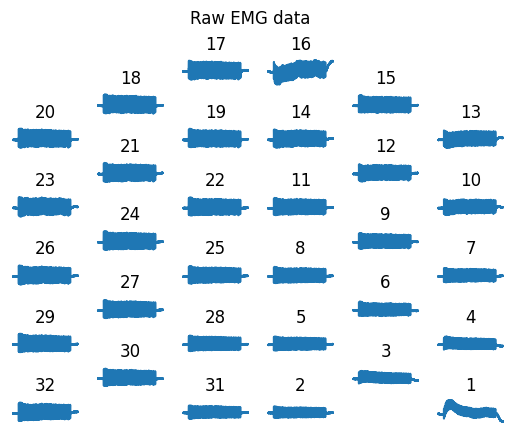

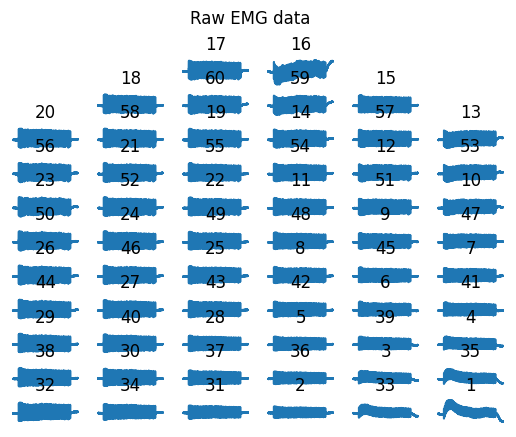

In [5]:

HD_sEMG_no_interp.plot_raw()
HD_sEMG_interp_raw.plot_raw()
plt.show()

## Plot original filtered data and interpolated filtered EMGs

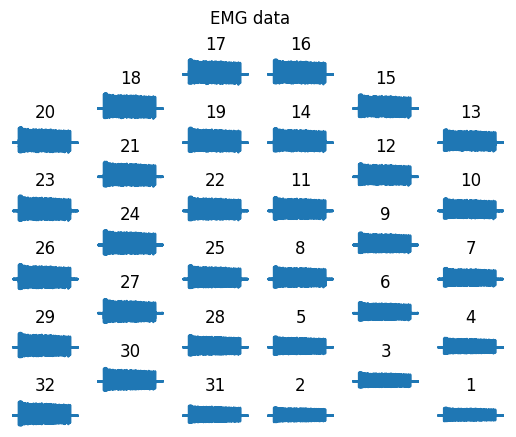

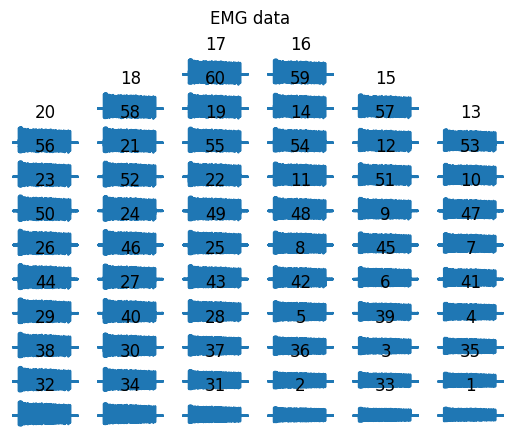

In [6]:
HD_sEMG_no_interp.plot_data()
HD_sEMG_interp.plot_data()
plt.show()

## Looking at eCMAPS

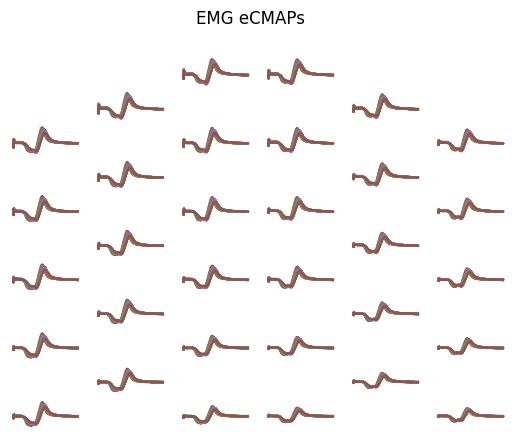

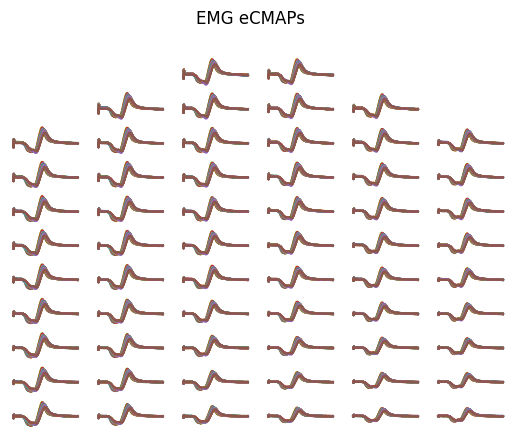

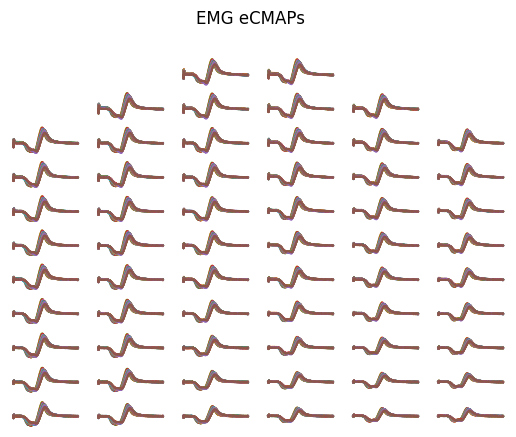

In [7]:
HD_sEMG_interp.trigger = trigger
HD_sEMG_interp_raw.trigger = trigger

HD_sEMG_no_interp.get_eCMAPS(duration = 0.015, delay = 0)
HD_sEMG_interp.get_eCMAPS(duration = 0.015, delay = 0)
HD_sEMG_interp_raw.get_eCMAPS(duration = 0.015, delay = 0)

HD_sEMG_no_interp.plot_eCMAPs(label=False)
HD_sEMG_interp.plot_eCMAPs(label=False)
HD_sEMG_interp_raw.plot_eCMAPs(label=False)
plt.show()

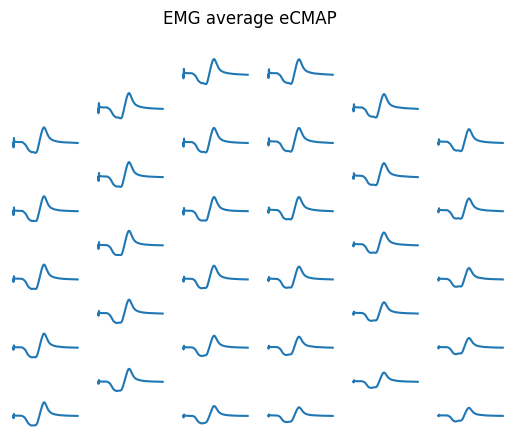

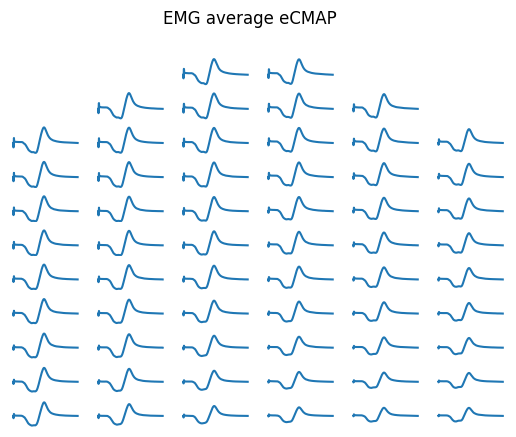

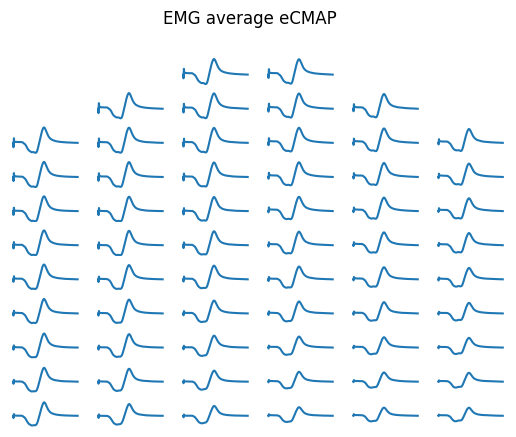

In [8]:
HD_sEMG_no_interp.plot_avg_eCMAP(label=False)
HD_sEMG_interp.plot_avg_eCMAP(label=False)
HD_sEMG_interp_raw.plot_avg_eCMAP(label=False)
plt.show()

## Plot heatmaps etc

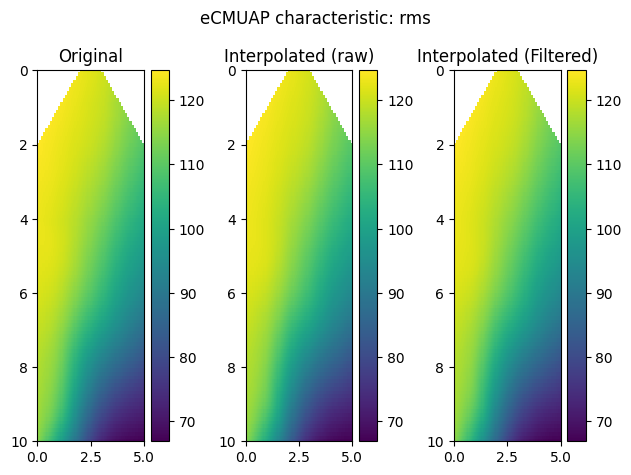

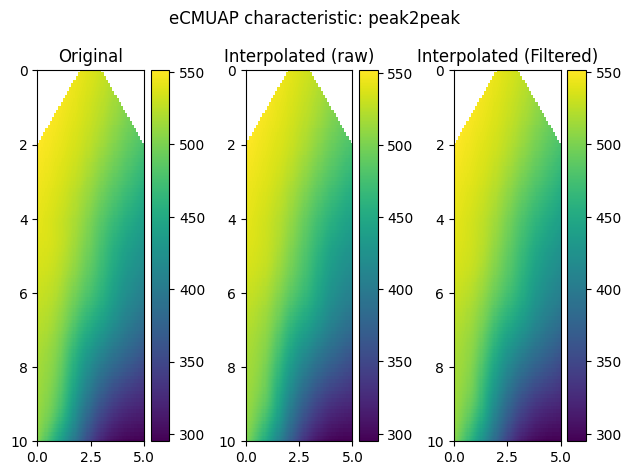

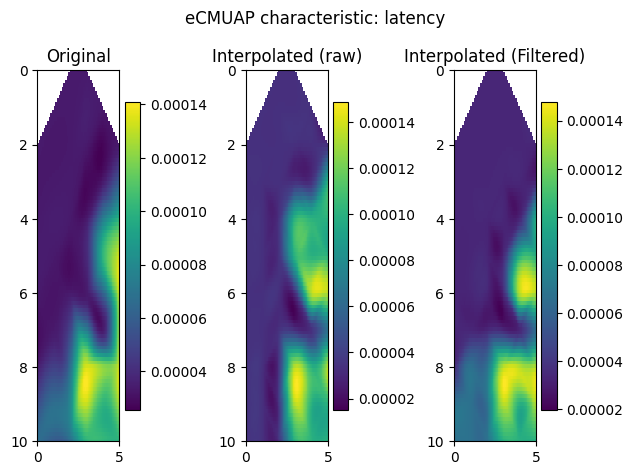

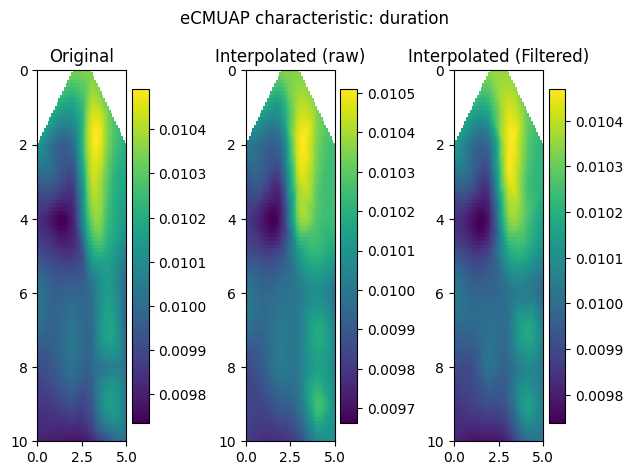

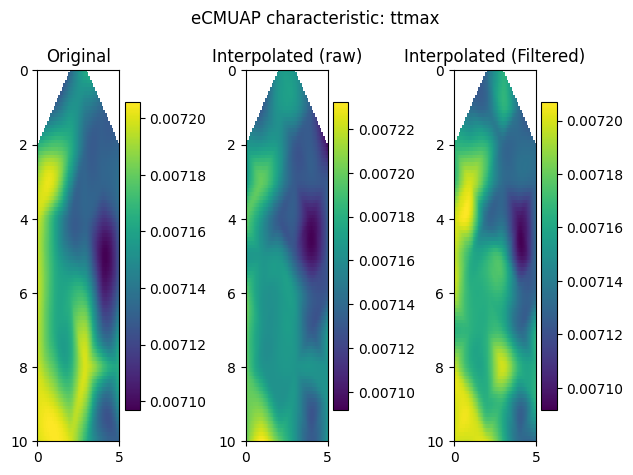

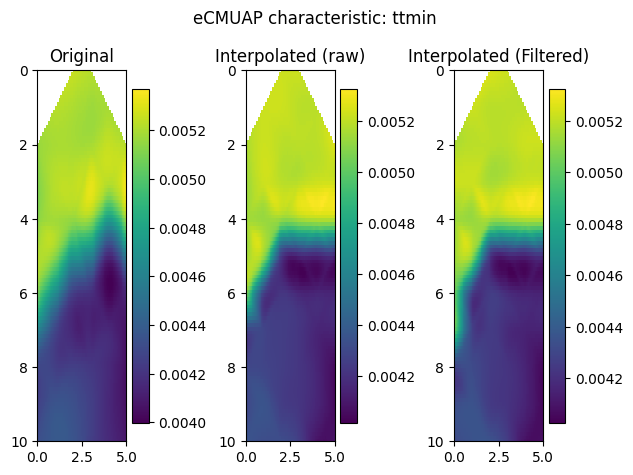

In [9]:
def plot_heatmap(data):
    fig, axs = plt.subplots(1,3) 
    sc = HD_sEMG_no_interp.plot_heatmap_eCMAP(axs[0], data, n_interp = 100)
    fig.colorbar(sc, ax = axs[0])
    sc = HD_sEMG_interp_raw.plot_heatmap_eCMAP(axs[1], data, n_interp = 100)
    fig.colorbar(sc, ax = axs[1])
    sc = HD_sEMG_interp.plot_heatmap_eCMAP(axs[2], data, n_interp = 100)
    fig.colorbar(sc, ax = axs[2])
    fig.suptitle(f"eCMUAP characteristic: {data}")
    axs[0].set_title("Original")
    axs[1].set_title("Interpolated (raw)")
    axs[2].set_title("Interpolated (Filtered)")
    fig.tight_layout()

plot_heatmap("rms")
plot_heatmap("peak2peak")
plot_heatmap("latency")
plot_heatmap("duration")
plot_heatmap("ttmax")
plot_heatmap("ttmin")
plt.show()

## 3D Timeshot and animation

In [10]:
min = HD_sEMG_no_interp.eEMGs[0].avg_eCMAP.min*1.2
max = HD_sEMG_no_interp.eEMGs[0].avg_eCMAP.max*1.2
n_interp = 15
def animate(i):
    fig, axs = plt.subplots(1,3,subplot_kw={"projection": "3d"})
    axs[0].set_zlim([-300, 300])
    axs[1].set_zlim([-300, 300])
    axs[2].set_zlim([-300, 300])
    HD_sEMG_no_interp.plot_avg_3D_timeshot(ax = axs[0], t_idx=i,n_interp = n_interp, min = min, max=max)
    HD_sEMG_interp_raw.plot_avg_3D_timeshot(ax = axs[1], t_idx=i,n_interp = n_interp, min = min, max=max)
    HD_sEMG_interp.plot_avg_3D_timeshot(ax = axs[2], t_idx=i,n_interp = n_interp, min = min, max=max)
    return(fig)

t = HD_sEMG_no_interp.eEMGs[0].avg_eCMAP.t

from neurotools.utils.plots import create_gif
create_gif(animate,len(t),"outputs/emg_array_interpolation.gif")


GIF creation: 100%|██████████| 449/449 [02:06<00:00,  3.55it/s]


Conversion to gif.... Done!
